In [4]:
from os import walk
import h5py
import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math
from os import walk
from skimage.transform import resize
from PIL import Image
import cv2
import functools
from sklearn.metrics import mean_squared_error

In [76]:
TIMESTEPS_X = 12
TIMESTEPS_Y = 6
NUMBER_OF_CHANNELS = 8
X_Seq = TIMESTEPS_X * NUMBER_OF_CHANNELS

def data_preprocessing(data, COVID):

   #combine dimensions of 288 and 8 as in the CNN paper
   def combine_dims(a, i=0, n=1):
     """
     Combines dimensions of numpy array `a`,
     starting at index `i`,
     and combining `n` dimensions
     """
     s = list(a.shape)
     combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
     return np.reshape(a, s[:i] + [combined] + s[i+n+1:])
    
    
    
   print(data.shape)
   data = data.swapaxes(0, 4)
   print(data.shape)
   data = combine_dims(data)

   print(data.shape)
   #divide the data by 255
   data = np.array(data)
   data = data / 255.
   data = data.swapaxes(0, 3)
   print(data.shape)
   
   return data


def open_file(file):
    with h5py.File(file, 'r') as hf:
                #get the data
                a_group_key = list(hf.keys())[0]
                test = list(hf[a_group_key])

 

                # transform to appropriate numpy array 
                test = test[0:]
                test = np.stack(test, axis=0)
                return test



In [69]:
#AVERAGE

def get_average_prediction(weights):
    losses = []
    test = open_file('BERLIN_test_temporal.h5')
    xs = []
    ys = []
    pred = []


    #load the data and split it into 13:3 chunks
    data = np.moveaxis(test, -1, 1)
    print(data.shape)
   
    x = data[1]
    print(x.shape)
    x = np.average(x, axis=1, weights=weights)
    x = np.expand_dims(x, axis=1)
    x = np.repeat(x, repeats=6, axis=1)
    # Convert the float value to uint8
    x = x.astype(np.uint8)
    # Set all speeds to 0 where there is no volume 
    x[:, :, :,  1] = x[:, :, :, 1] * (x[:, :, :,  0] > 0)
    x[:, :, :,  3] = x[:, :, :,  3] * (x[:, :, :,  2] > 0)
    x[:, :, :,  5] = x[:, :, :,  5] * (x[:, :, :,  4] > 0)
    x[:, :, :, 7] = x[:, :, :,  7] * (x[:, :, :,  6] > 0)
    print(x.shape)
    x = np.moveaxis(x, 1, 0)
    return x
        
            


In [127]:
def plot_vol_speed(data, timestep):
    timestep = data[timestep]
    avg_volume = timestep[0] + timestep[2] + timestep[4] + timestep[6]  /4.
    avg_speed = timestep[1] + timestep[3] + timestep[5] + timestep[7]  /4.

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(1,2) 
    f.set_figheight(15)
    f.set_figwidth(15)
    f.subplots_adjust(wspace=.01)
    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0].imshow(avg_volume)
    axarr[0].axis('off')
    axarr[0].title.set_text('Speed')
    axarr[1].imshow(avg_speed)
    axarr[1].title.set_text('Volume')
    axarr[1].axis('off')

In [148]:
def plot_vol_speed_unet(data, timestep):
    timestep = data[timestep*8:(timestep*8+8)]
    avg_speed = timestep[0] + timestep[2] + timestep[4] + timestep[6] /4.
    avg_volume = timestep[1] + timestep[3] + timestep[5] + timestep[7] /4.

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(1,2) 
    f.set_figheight(15)
    f.set_figwidth(15)
    f.subplots_adjust(wspace=.01)
    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0].imshow(avg_volume * 255.)
    axarr[0].axis('off')
    axarr[0].title.set_text('Speed')
    axarr[1].imshow(avg_speed * 255.)
    axarr[1].title.set_text('Volume')
    axarr[1].axis('off')
    plt.show()

In [77]:
model_berlin = tf.keras.models.load_model('BERLIN.h5', compile=False)

naive_average_weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
prediction_naive = get_average_prediction(naive_average_weights)

graph_predictions = open_file('graph_net_predictions.h5')
graph_predictions = np.moveaxis(graph_predictions, -1, 2)

ground_truths = open_file('BERLIN_test_temporal_groundtruth.h5')
ground_truths = np.moveaxis(ground_truths, -1, 2)

(100, 8, 12, 495, 436)
(8, 12, 495, 436)
(8, 6, 495, 436)


In [78]:
data = open_file('BERLIN_test_temporal.h5')
x = data_preprocessing(data, True)

(100, 12, 495, 436, 8)
(8, 12, 495, 436, 100)
(96, 495, 436, 100)
(100, 495, 436, 96)


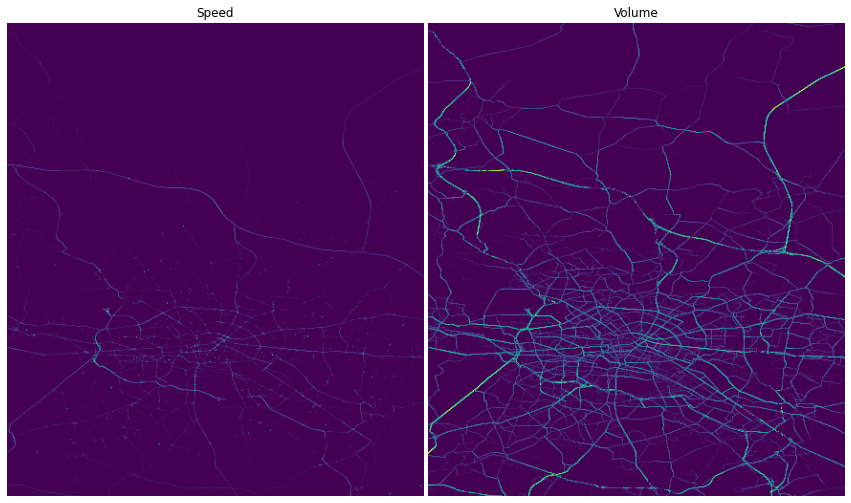

In [144]:
plot_vol_speed(graph_predictions[0], 4)

In [94]:
unet_prediction = model_berlin.predict(np.expand_dims(x[4], axis = 0))
unet_prediction = unet_prediction[:, 1:, 6:442, :]
unet_prediction = np.moveaxis(unet_prediction, -1, 1)
unet_prediction.shape

(1, 48, 495, 436)

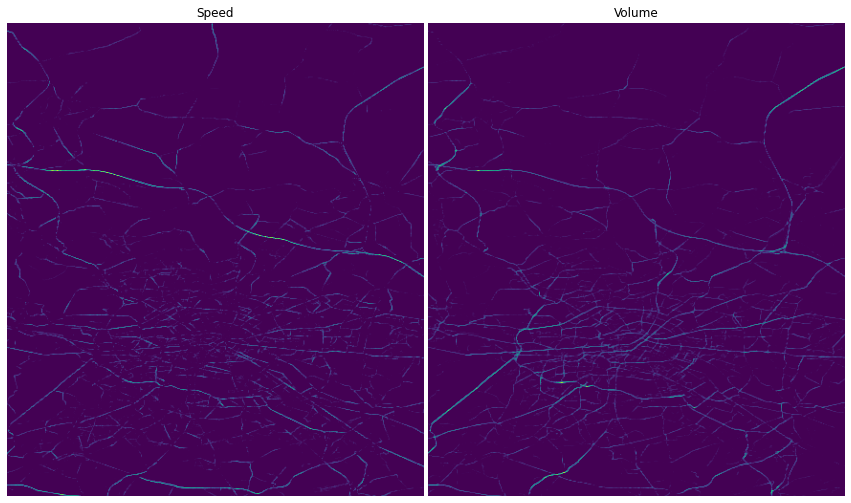

In [149]:
plot_vol_speed_unet(unet_prediction[0], 4)

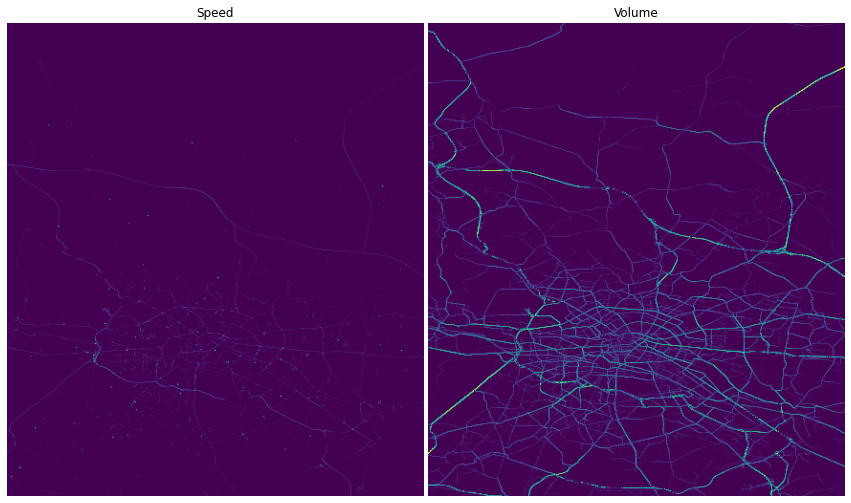

In [146]:
plot_vol_speed(prediction_naive, 4)

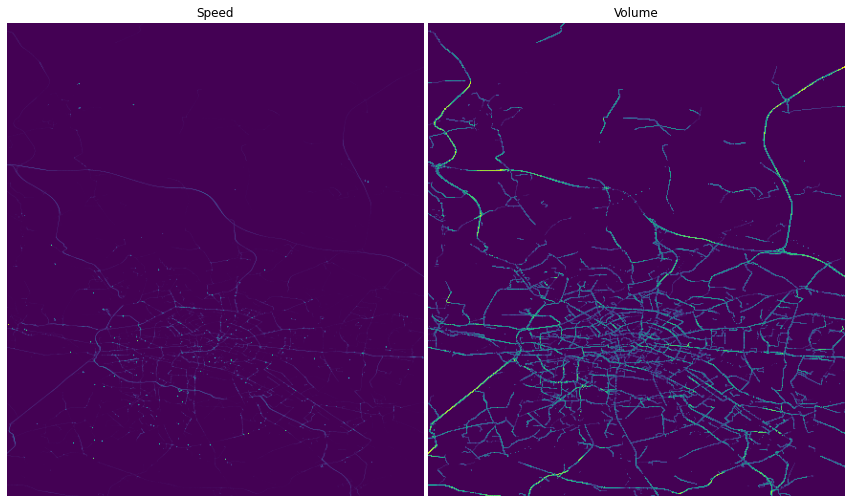

In [147]:
plot_vol_speed(ground_truths[0], 4)

In [153]:
#visualise inputs
inputs = np.moveaxis(data, -1, 2)

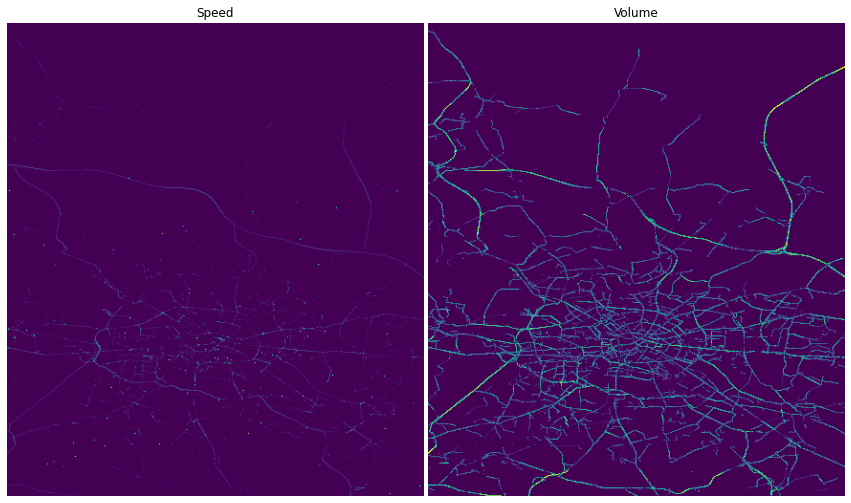

In [159]:
plot_vol_speed(inputs[0], 8)